[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stefmolin/pandas-workshop/main?urlpath=lab/tree/notebooks/3-data_visualization.ipynb) [![View slides in browser](https://img.shields.io/badge/view-slides-orange?logo=reveal.js&logoColor=white)](https://stefaniemolin.com/pandas-workshop/#/section-3)

---




# Section 3: Data Visualization

The human brain excels at finding patterns in visual representations of the data; so in this section, we will learn how to visualize data using pandas along with the Matplotlib and Seaborn libraries for additional features. We will create a variety of visualizations that will help us better understand our data.

## Why is data visualization necessary?

So far, we have focused a lot on summarizing the data using statistics. However, summary statistics are not enough to understand the distribution &ndash; there are many possible distributions for a given set of summary statistics. Data visualization is necessary to truly understand the distribution:

<div style="text-align: center; margin-top: -10px;">
<img width="50%" src="https://raw.githubusercontent.com/stefmolin/data-morph/main/docs/_static/panda-to-star-eased.gif" alt="Data Morph: panda to star" style="min-width: 300px; margin-bottom: -10px;"/>
<div style="margin: auto 26%;"><small><em>A set of points forming a panda can also form a star without any significant changes to the summary statistics displayed above. (source: <a href="https://github.com/stefmolin/data-morph">Data Morph</a>)</em></small></div>
</div>

## Plotting with pandas

We can create a variety of visualizations using the `plot()` method. In this section, we will take a brief tour of some of this functionality, which under the hood uses Matplotlib.

Once again, we will be working with the TSA traveler throughput data that we cleaned up in the previous section:

In [1]:
import pandas as pd

tsa_melted_holiday_travel = pd.read_csv(
    '../data/tsa_melted_holiday_travel.csv', 
    parse_dates=True, index_col='date'
)
tsa_melted_holiday_travel.head()

,year,travelers,holiday
date,,,
2019-01-01,2019,2126398.0,New Year's Day
2019-01-02,2019,2345103.0,New Year's Day
2019-01-03,2019,2202111.0,NaN
2019-01-04,2019,2150571.0,NaN
2019-01-05,2019,1975947.0,NaN


To embed SVG-format plots in the notebook, we will configure the Matplotlib plotting backend to generate SVG output (first argument) with custom metadata (second argument):

In [2]:
import matplotlib_inline
from utils import mpl_svg_config

matplotlib_inline.backend_inline.set_matplotlib_formats(
    'svg', # output images using SVG format
    **mpl_svg_config('section-3') # optional: configure metadata
)

*Note: The second argument is optional and is used here to make the SVG output reproducible by setting the `hashsalt` along with some metadata, which will be used by Matplotlib when generating any SVG output (see the `utils.py` file for more details). Without this argument, different runs of the same plotting code will generate plots that are visually identical, but differ at the HTML level due to different IDs, metadata, etc.*

### Line plots

The `plot()` method will generate line plots for all numeric columns by default:

<Axes: title={'center': '2020 TSA Traveler Throughput'}, xlabel='date', ylabel='travelers'>

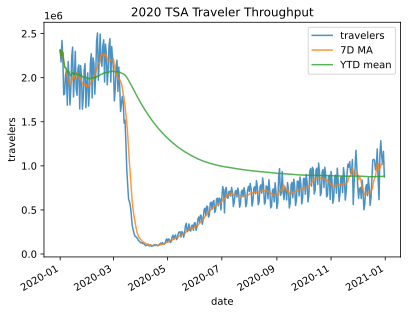

In [3]:
tsa_melted_holiday_travel.drop(columns='year').loc['2020'].assign(
    **{
        '7D MA': lambda x: x.travelers.rolling('7D').mean(),
        'YTD mean': lambda x: x.travelers.expanding().mean()
      }
).plot(title='2020 TSA Traveler Throughput', ylabel='travelers', alpha=0.8)

The `plot()` method returns an `Axes` object that can be modified further (e.g., to add reference lines, annotations, labels, etc.). Let's walk through an example.

### Bar plots

For our next example, we will plot vertical bars to compare monthly TSA traveler throughput across years. Let's start by creating a pivot table with the information we need:

In [4]:
plot_data = tsa_melted_holiday_travel['2019':'2021-04']\
    .assign(month=lambda x: x.index.month)\
    .pivot_table(index='month', columns='year', values='travelers', aggfunc='sum')
plot_data.head()

year,2019,2020,2021
month,,,
1,59405722.0,61930286.0,23598230.0
2,57345684.0,60428859.0,24446345.0
3,72530252.0,32995003.0,38050060.0
4,70518994.0,3322548.0,41826159.0
5,74617773.0,7244733.0,NaN


Pandas offers other plot types via the `kind` parameter, so we specify `kind='bar'` when calling the `plot()` method. Then, we further format the visualization using the `Axes` object returned by the `plot()` method:

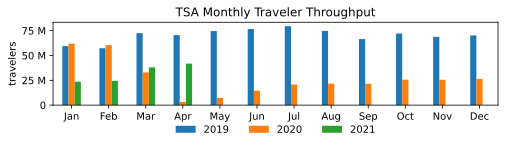

In [5]:
import calendar
from matplotlib import ticker

ax = plot_data.plot(
    kind='bar', rot=0, xlabel='', ylabel='travelers',
    figsize=(8, 1.5), title='TSA Monthly Traveler Throughput'
)

# use month abbreviations for the ticks on the x-axis
ax.set_xticklabels(calendar.month_abbr[1:])

# show y-axis labels in millions instead of scientific notation
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# customize the legend
ax.legend(title='', loc='center', bbox_to_anchor=(0.5, -0.3), ncols=3, frameon=False)

Some additional things to keep in mind:
- Matplotlib's `ticker` module provides functionality for customizing both the tick labels and locations &ndash; check out the [documentation](https://matplotlib.org/stable/api/ticker_api.html) for more information.
- Pandas supports horizontal and stacked bars as well; [this](https://medium.com/@stefaniemolin/how-to-pivot-and-plot-data-with-pandas-9450939fcf8) blog post shows how to make stacked horizontal bars using a pivot table.
- The `plot()` method takes a lot of [parameters](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html), many of which get passed down to Matplotlib; however, sometimes we need to use Matplotlib calls directly.

### Plotting distributions

Let's now compare the distribution of daily TSA traveler throughput across years. We will create a subplot for each year with both a histogram and a kernel density estimate (KDE) of the distribution.  Pandas has generated the `Figure` and `Axes` objects for both examples so far, but we can build custom layouts by creating them ourselves with Matplotlib using the `plt.subplots()` function. First, we will need to import the `pyplot` module:

In [6]:
import matplotlib.pyplot as plt

While pandas lets us specify that we want subplots and their layout (with the `subplots` and `layout` parameters, respectively), using Matplotlib to create the subplots directly gives us additional flexibility:

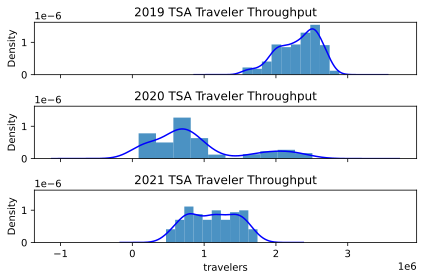

In [7]:
# define the subplot layout
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6, 4))

for year, ax in zip(tsa_melted_holiday_travel.year.unique(), axes):
    plot_data = tsa_melted_holiday_travel.loc[str(year)].travelers
    plot_data.plot(kind='hist', legend=False, density=True, alpha=0.8, ax=ax)
    plot_data.plot(kind='kde', legend=False, color='blue', ax=ax)
    ax.set(title=f'{year} TSA Traveler Throughput', xlabel='travelers')

fig.tight_layout() # handle overlaps

*Tip: If you're new to the `zip()` function, check out [this](https://realpython.com/python-zip-function/) article.*

### [Exercise 3.1](./workbook.ipynb#Exercise-3.1)

##### Using the TSA traveler throughput data in the `tsa_melted_holiday_travel.csv` file, create box plots for traveler throughput for each year in the data. Hint: Pass `kind='box'` into the `plot()` method to generate box plots.

In [8]:
# Complete this exercise in the workbook.ipynb file

In [9]:
# Click on `Exercise 3.1` above to open the workbook.ipynb file

In [10]:
# WARNING: if you complete the exercise here, your cell numbers
# for the rest of the training might not match the slides

## Plotting with Seaborn

The Seaborn library provides the means to easily visualize long-format data without first pivoting it. In addition, it also offers some additional plot types &ndash; once again building on top of Mtplotlib. Here, we will look at a few examples of visualizations we can create with Seaborn.

### Visualizing long-format data

With Seaborn, we can specify plot colors according to values of a column with the `hue` parameter. When working with functions that generate subplots, we can also specify how to split the subplots by values of a long-format column with the `col` and `row` parameters. Here, we revisit the comparison of the distribution of TSA traveler throughput across years:

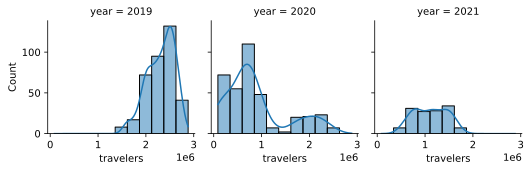

In [11]:
import seaborn as sns

sns.displot(
    data=tsa_melted_holiday_travel, x='travelers', col='year', kde=True, height=2.5
)

### Heatmaps
We can also use Seaborn to visualize pivot tables as heatmaps:

In [12]:
data = tsa_melted_holiday_travel['2019':'2021-04']\
    .assign(month=lambda x: x.index.month)\
    .pivot_table(index='month', columns='year', values='travelers', aggfunc='sum')

data

year,2019,2020,2021
month,,,
1,59405722.0,61930286.0,23598230.0
2,57345684.0,60428859.0,24446345.0
3,72530252.0,32995003.0,38050060.0
4,70518994.0,3322548.0,41826159.0
5,74617773.0,7244733.0,NaN
6,76619900.0,14481802.0,NaN
7,79511968.0,20740781.0,NaN
8,74776010.0,21708071.0,NaN
9,66531258.0,21488263.0,NaN


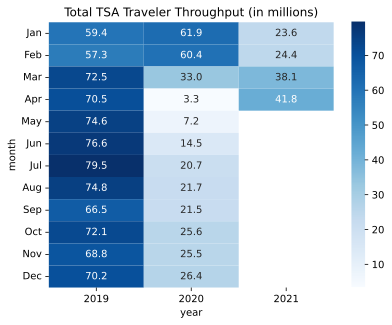

In [13]:
ax = sns.heatmap(data=data / 1e6, cmap='Blues', annot=True, fmt='.1f')
_ = ax.set_yticklabels(calendar.month_abbr[1:], rotation=0)
_ = ax.set_title('Total TSA Traveler Throughput (in millions)')

*Tip: Reference the Matplotlib documentation for more information on [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) and [named colors](https://matplotlib.org/stable/gallery/color/named_colors.html).*

We're moving on from Seaborn now, but there is a lot more available in the [API](https://seaborn.pydata.org/api.html). Be sure to check out the following at a minimum:
- [pairwise plots](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot) with `pairplot()`
- [categorical scatter plots](https://seaborn.pydata.org/generated/seaborn.swarmplot.html#seaborn.swarmplot) with `swarmplot()`
- [joint distribution plots](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot) with `jointplot()`
- [FacetGrids](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html#seaborn.FacetGrid) for custom layouts with any plot type

### [Exercise 3.2](./workbook.ipynb#Exercise-3.2)

##### Using the TSA traveler throughput data in the `tsa_melted_holiday_travel.csv` file, create a heatmap that shows the 2019 TSA median traveler throughput by day of week and month.

In [14]:
# Complete this exercise in the workbook.ipynb file

In [15]:
# Click on `Exercise 3.2` above to open the workbook.ipynb file

In [16]:
# WARNING: if you complete the exercise here, your cell numbers
# for the rest of the training might not match the slides

## Customizing plots with Matplotlib

In this final section, we will discuss how to use Matplotlib to customize plots. Since there is a lot of functionality available, we will only be covering how to add shaded regions and annotations here, but be sure to check out the [documentation](https://matplotlib.org/) for more.

### Adding shaded regions

When looking at a plot of TSA traveler throughput over time, it's helpful to indicate periods during which there was holiday travel. We can do so with the `axvspan()` method:

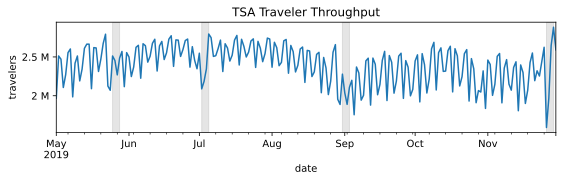

In [17]:
plot_data = tsa_melted_holiday_travel['2019-05':'2019-11']
ax = plot_data.travelers.plot(
    title='TSA Traveler Throughput', ylabel='travelers', figsize=(9, 2)
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# collect the holiday ranges (start and end dates)
holiday_ranges = plot_data.dropna().reset_index()\
    .groupby('holiday').agg({'date': ['min', 'max']})

# create shaded regions for each holiday in the plot
for start_date, end_date in holiday_ranges.to_numpy():
    ax.axvspan(start_date, end_date, color='gray', alpha=0.2)

*Tip: Use `axhspan()` for horizontally shaded regions and `axvline()` / `axhline()` for vertical/horizontal reference lines.*

### Adding annotations

We can use the `annotate()` method to add annotations to the plot. Here, we point out the day in 2019 with the highest TSA traveler throughput, which was the day after Thanksgiving:

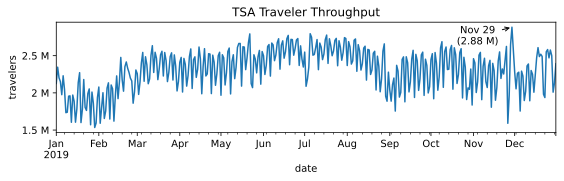

In [18]:
plot_data = tsa_melted_holiday_travel.loc['2019']
ax = plot_data.travelers.plot(
    title='TSA Traveler Throughput', ylabel='travelers', figsize=(9, 2)
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# highest throughput
max_throughput_date = plot_data.travelers.idxmax()
max_throughput = plot_data.travelers.max()
_ = ax.annotate(
    f'{max_throughput_date:%b %d}\n({max_throughput / 1e6:.2f} M)',
    xy=(max_throughput_date, max_throughput),
    xytext=(max_throughput_date - pd.Timedelta(days=25), max_throughput * 0.92),
    arrowprops={'arrowstyle': '->'}, ha='center'
)

Some things to keep in mind: 
- We used `Axes` methods to customize our plots (i.e., an object-oriented approach), but the `pyplot` module provides equivalent functions (i.e., a functional approach) for adding shaded regions, reference lines, annotations, etc. &ndash; although the function names might be slightly different than their `Axes` method counterparts (e.g., `Axes.set_xlabel()` vs. `plt.xlabel()`). 
- In general, try to stick to either the object-oriented or functional approach rather than mixing the two. However, be careful when working with subplots &ndash; `pyplot` functions will only affect the last subplot.
- The [anatomy of a figure](https://matplotlib.org/stable/gallery/showcase/anatomy.html) diagram in the Matplotlib documentation is a great resource for identifying which objects you will need to access for plot customizations.

For more on data visualization in Python, including animations and interactive plots, check out my [Beyond the Basics: Data Visualization in Python](https://github.com/stefmolin/python-data-viz-workshop) workshop.

### [Exercise 3.3](./workbook.ipynb#Exercise-3.3)

##### Annotate the medians in the box plot from *[Exercise 3.1](./workbook.ipynb#Exercise-3.1)*. Hint: The `x` coordinates will be 1, 2, and 3 for 2019, 2020, and 2021, respectively. Alternatively, to avoid hardcoding values, you can use the `Axes.get_xticklabels()` method, in which case you should look at the [documentation](https://matplotlib.org/stable/api/text_api.html) for the `Text` class.

In [19]:
# Complete this exercise in the workbook.ipynb file

In [20]:
# Click on `Exercise 3.3` above to open the workbook.ipynb file

In [21]:
# TIP: the solution to Exercise 3.1 can be found at
# https://stefaniemolin.com/pandas-workshop/#/solution-3-1

## Up Next: [Hands-On Data Analysis Lab](./4-hands_on_data_analysis_lab.ipynb)